# Import packages

In [45]:
from datetime import datetime, timedelta
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
np.random.seed(0)
import seaborn as sns
import requests
import statsmodels.api as sm
# from __future__ import division
# import plotly.plotly as py
# import plotly.offline as pyoff
# import plotly.graph_objs as go
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
# import hdbscan

from io import StringIO

import pandas as pd
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')


In [46]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

# **Setup helper functions**

In [3]:
# https://github.com/fivetran/analyst-recipes/blob/master/looker_api/looker_api_helpers.py

def generate_auth_token():

   """Generates an access token for the Looker API that can be passed in the required authorization header.
   These tokens expire in an hour"""

   data = {

     'client_id': 'FdKcD95jJjbjBSMpY8xr',  #replace this with client id

     'client_secret': 'n4ctjx5ZnYfV78WNGcXjkRmP' #replace this with client secret

   }

   auth_token = requests.post('https://carnextdoor.au.looker.com:19999/api/3.1/login', data=data)

   return auth_token.json().get('access_token')


def get_all_looks():
    """Returns all the looks in the looker environment"""
    looks = requests.get(URL + 'looks', headers=HEADERS)
    return looks.json()

def get_look(look_id):
    """Returns the look object for the specified look id"""
    look = requests.get('{}looks/{}'.format(URL, look_id), headers=HEADERS)
    return look.json()


def get_query(query_id):
    """Returns the query object for the specified id"""
    query = requests.get('{}queries/{}'.format(URL, query_id), headers=HEADERS)
    return query.json()

def run_query(query_id, results_format):
    """Returns the query result of the specified id in a specified format"""
    result = requests.get('{}queries/{}/run/{}'.format(URL, query_id, results_format), headers=HEADERS)
    return result
    
#GET/api/3.1/queries/{query_id}/run/{result_format}

In [4]:
HEADERS = {

   'Authorization': 'token {}'.format(generate_auth_token())

}

URL = 'https://carnextdoor.au.looker.com:19999/api/3.1/'


look_ids = [2978] #list all looks IDs here 

# Mount Google Drive (optional)

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

# **Querying data**

In [6]:
# d = {}

# for i in range(len(look_ids)):
#     query_id = get_look(look_ids[i]).get('query_id')
#     print('Running query id:{}'.format(query_id))
#     query_content = run_query(query_id, 'csv').content
#     print('Querying success! Saving to dataframe d[{}]'.format(i))
#     query_string = str(query_content,'utf-8')
#     d[i] = pd.read_csv(StringIO(query_string))
#     print('Dataframe d[{}] with {} rows created'.format(i, len(d[i])))
    
# print('All dataframes loaded on dictionary d')

In [7]:
# trip_details = d[0].copy(deep=True)

In [8]:
# trip_details.to_csv('/content/drive/MyDrive/Colab Notebooks/trip_details.csv', index=False)
# trip_details.to_csv('trip_details.csv', index=False)

In [129]:
# trip_details = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/trip_details.csv')
trip_details = pd.read_csv('trip_details.csv')

In [130]:
trip_details.head()

,Members ID,Addresses State,Addresses Latitude,Addresses Longitude,Trips ID,Trips Created Date,Trips End Date,Cars ID,Trips - Homezone (at time of booking) State,Trips - Homezone (at time of booking) Latitude,Trips - Homezone (at time of booking) Longitude,Cars Body Type Class,Trips Billing Distance,Trips Hours Duration,Trips Completed (Yes / No),Trips Start Date,Members Age,Members Age Tier,Applicants Gender,Trips Count
0,1001,NSW,-33.805412,151.260579,1090474,2021-06-01,2021-09-08,2.0,Queensland,-16.900039,145.758048,SUV / 4WD,0,168 hours,No,2021-09-01,42,35 to 44,NaN,1
1,33333,VIC,-37.775968,144.949683,1159098,2021-09-11,2021-09-12,NaN,Victoria,-37.737681,145.009625,Car,34,23 hours,Yes,2021-09-11,30,30 to 34,male,1
2,33333,VIC,-37.775968,144.949683,1150218,2021-08-27,2021-08-28,NaN,Victoria,-37.737681,145.009625,Car,97,23 hours,Yes,2021-08-27,30,30 to 34,male,1
3,33333,VIC,-37.775968,144.949683,1140415,2021-08-10,2021-08-10,NaN,Victoria,-33.860000,151.209400,Car,23,2 hours,Yes,2021-08-10,30,30 to 34,male,1
4,33333,VIC,-37.775968,144.949683,1140415,2021-08-10,2021-08-10,NaN,Victoria,-37.726564,145.001440,Car,23,2 hours,Yes,2021-08-10,30,30 to 34,male,1


In [131]:
trip_details.columns.to_list()

['Members ID',
 'Addresses State',
 'Addresses Latitude',
 'Addresses Longitude',
 'Trips ID',
 'Trips Created Date',
 'Trips End Date',
 'Cars ID',
 'Trips - Homezone (at time of booking) State',
 'Trips - Homezone (at time of booking) Latitude',
 'Trips - Homezone (at time of booking) Longitude',
 'Cars Body Type Class',
 'Trips Billing Distance',
 'Trips Hours Duration',
 'Trips Completed (Yes / No)',
 'Trips Start Date',
 'Members Age',
 'Members Age Tier',
 'Applicants Gender',
 'Trips Count']

In [132]:
trip_details.columns = ['member_id',
 'member_state',
 'member_lat',
 'member_lon',
 'trip_id',
 'trip_created',
 'trip_end',
 'car_id',
 'car_state',
 'car_lat',
 'car_lon',
 'car_type',
 'trip_distance',
 'trip_duration',
 'trip_completed',
 'trip_start',
 'age',
 'age_tier',
 'gender',
 'count']

In [133]:
trip_details.dtypes

member_id           int64
member_state       object
member_lat        float64
member_lon        float64
trip_id             int64
trip_created       object
trip_end           object
car_id            float64
car_state          object
car_lat           float64
car_lon           float64
car_type           object
trip_distance       int64
trip_duration      object
trip_completed     object
trip_start         object
age                 int64
age_tier           object
gender             object
count               int64
dtype: object

In [134]:
trip_details.head()

,member_id,member_state,member_lat,member_lon,trip_id,trip_created,trip_end,car_id,car_state,car_lat,car_lon,car_type,trip_distance,trip_duration,trip_completed,trip_start,age,age_tier,gender,count
0,1001,NSW,-33.805412,151.260579,1090474,2021-06-01,2021-09-08,2.0,Queensland,-16.900039,145.758048,SUV / 4WD,0,168 hours,No,2021-09-01,42,35 to 44,NaN,1
1,33333,VIC,-37.775968,144.949683,1159098,2021-09-11,2021-09-12,NaN,Victoria,-37.737681,145.009625,Car,34,23 hours,Yes,2021-09-11,30,30 to 34,male,1
2,33333,VIC,-37.775968,144.949683,1150218,2021-08-27,2021-08-28,NaN,Victoria,-37.737681,145.009625,Car,97,23 hours,Yes,2021-08-27,30,30 to 34,male,1
3,33333,VIC,-37.775968,144.949683,1140415,2021-08-10,2021-08-10,NaN,Victoria,-33.860000,151.209400,Car,23,2 hours,Yes,2021-08-10,30,30 to 34,male,1
4,33333,VIC,-37.775968,144.949683,1140415,2021-08-10,2021-08-10,NaN,Victoria,-37.726564,145.001440,Car,23,2 hours,Yes,2021-08-10,30,30 to 34,male,1


# Initial data checks

How many trips had null as car id

In [135]:
trip_details[trip_details['car_id'].isnull()].groupby('trip_completed').count()[['member_id']]

,member_id
trip_completed,
No,28178
Yes,250690


How many trips had available car id

In [136]:
trip_details[~(trip_details['car_id'].isnull())].groupby('trip_completed').count()[['member_id']]

,member_id
trip_completed,
No,2661
Yes,16342


Looking at top 10 member states

In [137]:
trip_details.groupby(['member_state']).count()[['member_id']].sort_values('member_id',ascending=False).head(10)

,member_id
member_state,
NSW,152367
VIC,104575
QLD,31425
WA,4655
ACT,2139
SA,788
TAS,756
NT,273
England,215


Breaking down trips based on car types

In [138]:
trip_details.groupby(['car_type']).count()[['member_id']].sort_values('member_id',ascending=False).head(10)

,member_id
car_type,
Car,291844
SUV / 4WD,2934
Van / People Mover,2408
Ute,685


.. Only a very small percentage of trips were taken in Ute / Van vehicles

In [139]:
print("Trips with 0 trip distance:", trip_details[trip_details['trip_distance'] == 0].count()[['count']][0])

Trips with 0 trip distance: 37040


In [140]:
 trip_details[trip_details['trip_distance'] == 0].groupby(['trip_completed']).count()[['member_id']]

,member_id
trip_completed,
No,30839
Yes,6201


>10 % of trips have 0 trip distance

In [141]:
trip_details[(trip_details['trip_distance'] == 0) & (trip_details['trip_completed'] == "Yes")].groupby('trip_duration').count()[['count']].head(10)

,count
trip_duration,
0 hours,5
1 hour,4574
10 hours,40
101 hours,1
102 hours,1
11 hours,29
110 hours,1
117 hours,1
118 hours,3


Most of the trips with 0 distance only had 1 hour duration. From here, we can safely remove these trips from the analysis

In [142]:
trip_details[trip_details['trip_start'].isnull()].count()[['member_id']]

member_id    0
dtype: int64

# Data Manipulation

## Add month column

In [143]:
trip_details['end_month'] = trip_details['trip_end'].str[:7]

## Add distance column

In [144]:
trip_details['borrower_distance'] = trip_details[['member_lon', 'member_lat', 'car_lon', 'car_lat']].apply(lambda row: haversine(row['member_lon'], row['member_lat'], row['car_lon'], row['car_lat']), axis=1)

## Add time to book (time from trip creation to trip start) 

In [145]:
trip_details[['trip_created','trip_start']] = trip_details[['trip_created','trip_start']].apply(pd.to_datetime) #if conversion required
trip_details['time_to_book'] = (trip_details['trip_start'] - trip_details['trip_created']).dt.days
trip_details[['time_to_book']].describe()

,time_to_book
count,297871.000000
mean,2.616921
std,12.251915
min,-105.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,1840.000000


In [146]:
trip_details = trip_details.drop(index = trip_details[trip_details['time_to_book'] < 0].index)

In [147]:
trip_details[['time_to_book','trip_distance']].corr()

,time_to_book,trip_distance
time_to_book,1.000000,0.038173
trip_distance,0.038173,1.000000


## Remove borrowers from foreign addresses

In [148]:
trip_details = trip_details[trip_details['member_state'].isin(['NSW', 'VIC', 'QLD', 'WA', 'ACT', 'TAS', 'SA', 'NT'])]


## Align car state syntax

In [149]:
trip_details.loc[trip_details['car_state'] == 'New South Wales', 'car_state'] = 'NSW'
trip_details.loc[trip_details['car_state'] == 'Queensland', 'car_state'] = 'QLD'
trip_details.loc[trip_details['car_state'] == 'Victoria', 'car_state'] = 'VIC'
trip_details.loc[trip_details['car_state'] == 'Australian Capital Territory', 'car_state'] = 'ACT'
trip_details.loc[trip_details['car_state'] == 'Tasmania', 'car_state'] = 'TAS'
trip_details.loc[trip_details['car_state'] == 'Western Australia', 'car_state'] = 'WA'
trip_details.loc[trip_details['car_state'] == 'South Australia', 'car_state'] = 'SA'
trip_details.loc[trip_details['car_state'] == 'Northern Territory', 'car_state'] = 'NT'

## Fix trip duration column

In [150]:
trip_details['trip_duration'] = trip_details['trip_duration'].str.split(' ', expand=True)[0]
trip_details['trip_duration'] = trip_details['trip_duration'].astype(int)

## Car borrowers

In [151]:
car_borrowers = trip_details[(trip_details['car_type'].isin(['Car','SUV / 4WD'])) & 
                             (trip_details['trip_completed'] == 'Yes') & 
                             (trip_details['trip_distance'] > 0)].copy(deep=True)

## Van / Ute borrowers

In [152]:
ute_borrowers = trip_details[trip_details['car_type'].isin(['Van / People Mover','Ute']) & 
                             (trip_details['trip_completed'] == 'Yes') & 
                             (trip_details['trip_distance'] > 0)].copy(deep=True)

In [153]:
ute_borrowers[ute_borrowers['member_state'] == 'NSW']

,member_id,member_state,member_lat,member_lon,trip_id,trip_created,trip_end,car_id,car_state,car_lat,car_lon,car_type,trip_distance,trip_duration,trip_completed,trip_start,age,age_tier,gender,count,end_month,borrower_distance,time_to_book
44,33251,NSW,-33.912221,151.210080,1130804,2021-07-25,2021-07-26,1962.0,NSW,-33.912970,151.210090,Ute,13,1,Yes,2021-07-26,41,35 to 44,male,1,2021-07,0.083290,1
46,33251,NSW,-33.912221,151.210080,1124772,2021-07-15,2021-07-15,1962.0,NSW,-33.925836,151.199294,Ute,8,1,Yes,2021-07-15,41,35 to 44,male,1,2021-07,1.811761,0
48,33251,NSW,-33.912221,151.210080,1095827,2021-06-08,2021-06-11,1962.0,NSW,-33.909342,151.205701,Ute,22,1,Yes,2021-06-11,41,35 to 44,male,1,2021-06,0.515539,3
50,33251,NSW,-33.912221,151.210080,893934,2020-10-11,2020-10-24,1962.0,NSW,-33.930164,151.148591,Ute,236,308,Yes,2020-10-11,41,35 to 44,male,1,2020-10,6.014189,0
548,33513,NSW,-33.888234,151.137088,902436,2020-10-25,2020-10-25,3981.0,NSW,-33.860101,151.174455,Van / People Mover,18,4,Yes,2020-10-25,26,25 to 29,female,1,2020-10,4.656908,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296157,5843,NSW,-33.888790,151.241441,1030513,2021-03-26,2021-03-26,10534.0,NSW,-33.899142,151.248081,Ute,52,1,Yes,2021-03-26,40,35 to 44,NaN,1,2021-03,1.304077,0
297576,1322,NSW,-33.909706,151.200281,1055160,2021-04-22,2021-06-14,1870.0,NSW,-28.180103,153.528170,Van / People Mover,565,55,Yes,2021-06-12,56,45 or Above,NaN,1,2021-06,674.533705,51
297578,1322,NSW,-33.909706,151.200281,906398,2020-10-30,2020-10-31,1870.0,NSW,-33.913133,151.200071,Van / People Mover,16,2,Yes,2020-10-31,56,45 or Above,NaN,1,2020-10,0.381557,1
297584,1303,NSW,-33.834061,151.228703,988887,2021-02-08,2021-02-09,141686.0,NSW,-33.818003,150.985666,Van / People Mover,294,24,Yes,2021-02-08,41,35 to 44,NaN,1,2021-02,22.520982,0


# Separate data per state / city

In [154]:
car_borrowers.describe()

,member_id,member_lat,member_lon,trip_id,car_id,car_lat,car_lon,trip_distance,trip_duration,age,count,borrower_distance,time_to_book
count,257668.000000,257147.000000,257147.000000,2.576680e+05,13354.000000,256480.000000,256480.000000,257668.000000,257668.000000,257668.000000,257668.0,255960.000000,257668.000000
mean,424317.550860,-34.530585,148.575331,1.024897e+06,100161.322450,-34.354174,148.732314,116.488629,25.525308,34.330887,1.0,106.981858,1.766839
std,214903.655722,3.287599,5.369086,7.902755e+04,68420.291555,3.511773,5.146194,197.360209,61.331837,8.923927,0.0,418.282546,4.348970
min,1012.000000,-43.337608,-122.567078,8.873580e+05,11.000000,-43.068216,115.692788,1.000000,0.000000,19.000000,1.0,0.000000,0.000000
25%,245078.250000,-37.779262,145.000508,9.567608e+05,15828.750000,-37.776551,145.003772,25.000000,2.000000,28.000000,1.0,0.627624,0.000000
50%,485729.500000,-33.905791,151.142912,1.025770e+06,142978.500000,-33.901723,151.160922,53.000000,8.000000,32.000000,1.0,1.945393,1.000000
75%,603007.250000,-33.863455,151.234777,1.093194e+06,156403.000000,-33.860000,151.238375,123.000000,24.000000,38.000000,1.0,6.565716,2.000000
max,733365.000000,52.818691,180.000000,1.161963e+06,174855.000000,-12.462360,153.620348,11370.000000,3767.000000,84.000000,1.0,17318.774541,240.000000


In [155]:
car_NSW = car_borrowers[car_borrowers['car_state'].isin(['NSW'])].copy(deep=True) 

## Define the feature variables 

In [36]:
X = car_NSW[['borrower_distance', 'trip_duration', 'trip_distance','time_to_book']]

In [37]:
X.quantile(.99)

borrower_distance    818.818392
trip_duration        215.000000
trip_distance        781.000000
time_to_book          17.000000
Name: 0.99, dtype: float64

In [38]:
X = X[X['borrower_distance'] <= X.quantile(.99)[0]]
X = X[X['trip_duration'] <= X.quantile(.99)[1]]
X = X[X['trip_distance'] <= X.quantile(.99)[2]]

In [39]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(data=X_scaled, columns=X.columns)
X_scaled

,borrower_distance,trip_duration,trip_distance,time_to_book
0,-0.209744,0.158805,-0.475999,-0.395437
1,-0.212235,-0.623886,-0.771005,-0.395437
2,-0.209142,-0.549344,0.456599,-0.395437
3,-0.206985,-0.288447,0.428050,1.881694
4,-0.214226,0.270618,-0.694874,-0.110796
...,...,...,...,...
127744,-0.210462,0.196076,-0.447450,-0.395437
127745,-0.210462,0.568785,-0.247608,0.458487
127746,-0.210988,-0.288447,-0.304706,-0.395437
127747,-0.209050,-0.251176,-0.352287,-0.395437


# K-means
Test k-means clustering for NSW data using borrower distance and trip duration

In [40]:
var1 = 'borrower_distance'
var2 = 'trip_distance'

In [41]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_scaled[[var1, var2]])

In [42]:
cluster_centers = pd.DataFrame(columns=[var1, var2], data = kmeans.cluster_centers_)
cluster_centers

,borrower_distance,trip_distance
0,-0.186585,-0.497821
1,5.379036,0.436602
2,-0.168965,1.633118
3,-0.161198,3.798489
4,-0.175297,0.252322


In [43]:
cluster_centers.dtypes

borrower_distance    float64
trip_distance        float64
dtype: object

<AxesSubplot:xlabel='borrower_distance', ylabel='trip_distance'>

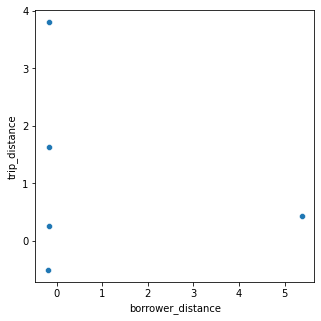

In [44]:
plt.figure(figsize=(5,5))
sns.scatterplot(data=cluster_centers, x=var1, y=var2)

In [45]:
X['kmeans'] = kmeans.labels_

In [46]:
X.groupby(['kmeans']).agg(['count','mean']).sort_values(by=('trip_distance','mean'))

borrower_distance             trip_duration            trip_distance             time_to_book          
                   count        mean         count       mean         count        mean        count      mean
kmeans                                                                                                        
0                  82241    3.807798         82241   8.103452         82241   30.700721        82241  0.987926
4                  27446    5.213130         27446  26.425344         27446  109.512679        27446  1.591926
1                   4177  693.958649          4177  27.119943          4177  128.898731         4177  2.097438
2                   9485    5.996871          9485  49.980812          9485  254.624354         9485  2.568371
3                   4400    6.957704          4400  65.252273          4400  482.175227         4400  4.412045

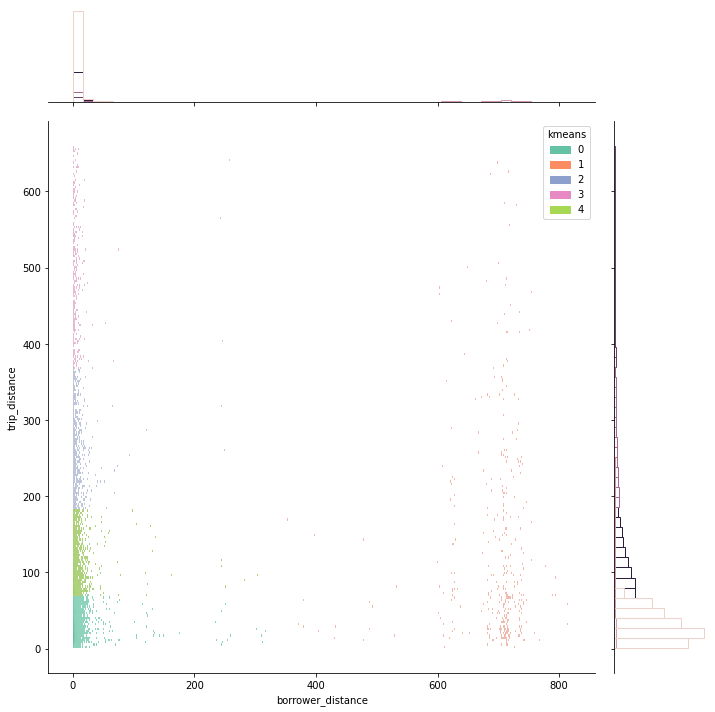

In [47]:
%matplotlib inline
# plt.figure(figsize=(20,20))
sns.jointplot(data=X, x=var1, y=var2, kind="hist", 
              marginal_kws=dict(bins=50, fill=False),
              hue="kmeans", height=10, palette="Set2")
# plt.xlim(0,700)
# plt.ylim(0,150)
# plt.show()

In [48]:
X.groupby(['kmeans']).describe()

borrower_distance                                                                                    trip_duration                                                     trip_distance                                                            time_to_book                                               
                   count        mean        std         min         25%         50%         75%         max         count       mean        std  min   25%   50%   75%    max         count        mean         std    min    25%    50%    75%    max        count      mean       std  min  25%  50%  75%    max
kmeans                                                                                                                                                                                                                                                                                                            
0                82241.0    3.807798  13.761414    0.000000    0.391812    1.010452    3.517684  353.928708       82241.0   8.103452  12.362025  0.0   1.0   3.0   9.0  207.0       82241.0   30.700721   17.960824    1.0   16.0   28.0   44.0   70.0      82241.0  0.987926  2.458204  0.0  0.0  0.0  1.0   91.0
1                 4177.0  693.958649  60.304394  349.619966  691.656758  710.605316  718.053527  818.790997        4177.0  27.119943  34.575120  1.0   4.0  11.0  38.0  214.0        4177.0  128.898731  131.960878    1.0   33.0   81.0  184.0  652.0       4177.0  2.097438  5.409109  0.0  0.0  1.0  2.0   80.0
2                 9485.0    5.996871  17.436011    0.000000    0.653446    1.729428    5.315703  378.586160        9485.0  49.980812  41.762406  1.0  16.0  40.0  71.0  214.0        9485.0  254.624354   51.132803  182.0  211.0  245.0  293.0  368.0       9485.0  2.568371  5.475810  0.0  0.0  1.0  3.0   84.0
3                 4400.0    6.957704  24.686609    0.000000    0.684390    1.971122    5.581336  546.101643        4400.0  65.252273  41.390659  1.0  36.0  55.0  81.0  214.0        4400.0  482.175227   80.506012  369.0  413.0  467.0  544.0  660.0       4400.0  4.412045  7.763555  0.0  1.0  2.0  5.0   77.0
4                27446.0    5.213130  15.655330    0.000000    0.592156    1.601255    5.040145  348.865429       27446.0  26.425344  27.303081  1.0   8.0  21.0  33.0  214.0       27446.0  109.512679   29.926739   68.0   84.0  103.0  130.0  182.0      27446.0  1.591926  3.510552  0.0  0.0  1.0  2.0  115.0

In [49]:
X.groupby(['kmeans']).count()['trip_duration']

kmeans
0    82241
1     4177
2     9485
3     4400
4    27446
Name: trip_duration, dtype: int64

## 2nd layer k-means

In [50]:
X_2 = X[X['borrower_distance'] <= 100].copy(deep=True)

In [51]:
scaler = StandardScaler()
scaler.fit(X_2[['borrower_distance', 'trip_duration', 'trip_distance']])
X_2_scaled = scaler.transform(X_2[['borrower_distance', 'trip_duration', 'trip_distance']])
X_2_scaled = pd.DataFrame(data=X_2_scaled, columns=['borrower_distance', 'trip_duration', 'trip_distance'])
X_2_scaled

,borrower_distance,trip_duration,trip_distance
0,-0.395168,0.173253,-0.466873
1,-0.442085,-0.620394,-0.766419
2,-0.383835,-0.544808,0.480080
3,-0.343190,-0.280259,0.451092
4,-0.479607,0.286632,-0.689117
...,...,...,...
122991,-0.408692,0.211046,-0.437885
122992,-0.408692,0.588973,-0.234966
122993,-0.418595,-0.280259,-0.292943
122994,-0.382100,-0.242467,-0.341257


In [52]:
var1 = 'borrower_distance'
var2 = 'trip_distance'

In [53]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_2_scaled[[var1, var2]])

In [54]:
cluster_centers = pd.DataFrame(columns=[var1, var2], data = kmeans.cluster_centers_)
cluster_centers

,borrower_distance,trip_distance
0,0.050932,3.483816
1,-0.270667,-0.413869
2,8.023167,0.458601
3,1.743826,-0.091748
4,-0.171994,0.916700


In [55]:
cluster_centers.dtypes

borrower_distance    float64
trip_distance        float64
dtype: object

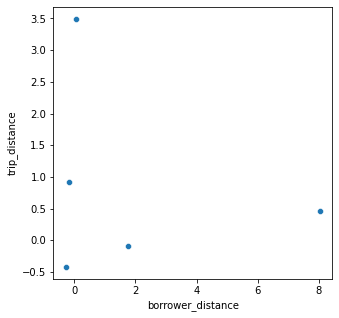

In [56]:
plt.figure(figsize=(5,5))
sns.scatterplot(data=cluster_centers, x=var1, y=var2)
plt.show()

In [57]:
X_2['kmeans'] = kmeans.labels_

In [58]:
X_2.groupby(['kmeans']).agg(['count','mean']).sort_values(by=('trip_distance','mean'))

borrower_distance            trip_duration            trip_distance             time_to_book          
                   count       mean         count       mean         count        mean        count      mean
kmeans                                                                                                       
1                  87374   1.756817         87374  10.143338         87374   38.483061        87374  1.048413
3                  11267  15.010430         11267  15.416260         11267   71.787610        11267  1.371439
2                    841  56.302955           841  21.084423           841  128.816885          841  1.550535
4                  17569   2.406960         17569  39.234276         17569  176.173829        17569  1.977290
0                   5945   3.874358          5945  63.088814          5945  441.856013         5945  4.137090

<Figure size 1440x1440 with 0 Axes>

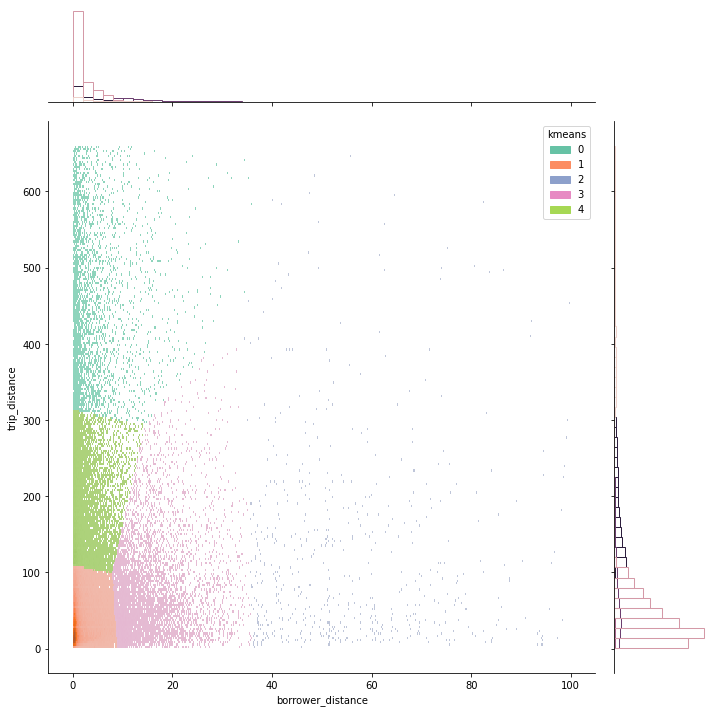

In [59]:
plt.figure(figsize=(20,20))
sns.jointplot(data=X_2, x=var1, y=var2, kind="hist", 
              marginal_kws=dict(bins=50, fill=False),
              hue="kmeans", height=10, palette="Set2")
# plt.xlim(0,700)
# plt.ylim(0,50)
plt.show()

In [60]:
X_2.groupby(['kmeans']).describe().sort_values(by=('borrower_distance','max'))

borrower_distance                                                                              trip_duration                                                     trip_distance                                                            time_to_book                                               
                   count       mean        std        min        25%        50%        75%        max         count       mean        std  min   25%   50%   75%    max         count        mean         std    min    25%    50%    75%    max        count      mean       std  min  25%  50%  75%    max
kmeans                                                                                                                                                                                                                                                                                                      
1                87374.0   1.756817   1.981380   0.000000   0.367722   0.862844   2.487371   8.860414       87374.0  10.143338  14.982707  0.0   2.0   4.0  12.0  214.0       87374.0   38.483061   26.175199    1.0   17.0   32.0   55.0  109.0      87374.0  1.048413  2.481583  0.0  0.0  0.0  1.0   66.0
4                17569.0   2.406960   2.499976   0.000000   0.569669   1.370883   3.511606  14.137926       17569.0  39.234276  36.597723  1.0  11.0  25.0  51.0  214.0       17569.0  176.173829   55.861750  101.0  128.0  161.0  218.0  312.0      17569.0  1.977290  4.486305  0.0  0.0  1.0  2.0  115.0
3                11267.0  15.010430   5.787067   7.958662  10.426000  13.215213  18.112099  35.862584       11267.0  15.416260  23.706711  0.0   2.0   6.0  22.0  214.0       11267.0   71.787610   60.006977    1.0   30.0   55.0   95.0  425.0      11267.0  1.371439  3.556929  0.0  0.0  0.0  1.0   91.0
0                 5945.0   3.874358   5.026406   0.000000   0.663720   1.770528   5.012484  36.199677        5945.0  63.088814  41.768636  1.0  34.0  53.0  80.0  214.0        5945.0  441.856013   94.792998  295.0  361.0  424.0  510.0  660.0       5945.0  4.137090  7.530973  0.0  0.0  1.0  4.0   77.0
2                  841.0  56.302955  16.349189  34.409794  42.074747  51.977551  67.738681  99.954448         841.0  21.084423  31.357140  1.0   3.0   8.0  24.0  211.0         841.0  128.816885  131.604222    2.0   30.0   84.0  186.0  646.0        841.0  1.550535  3.869001  0.0  0.0  1.0  2.0   78.0

In [61]:
X_2.groupby(['kmeans']).count()['trip_duration']

kmeans
0     5945
1    87374
2      841
3    11267
4    17569
Name: trip_duration, dtype: int64

## Use time to book as another dimension to split travellers from inter-city borrowers 

In [62]:
X_3 = X[X['borrower_distance'] > 8].copy(deep=True)

In [63]:
X_3[['time_to_book','trip_distance','borrower_distance']].corr()

,time_to_book,trip_distance,borrower_distance
time_to_book,1.000000,0.194483,0.048264
trip_distance,0.194483,1.000000,0.093483
borrower_distance,0.048264,0.093483,1.000000


In [64]:
X_3.quantile(.95)

borrower_distance    719.687266
trip_duration         91.150000
trip_distance        385.000000
time_to_book           7.000000
kmeans                 4.000000
Name: 0.95, dtype: float64

In [65]:
X_3[X_3['trip_distance'] > 800]

,borrower_distance,trip_duration,trip_distance,time_to_book,kmeans


<Figure size 1080x1080 with 0 Axes>

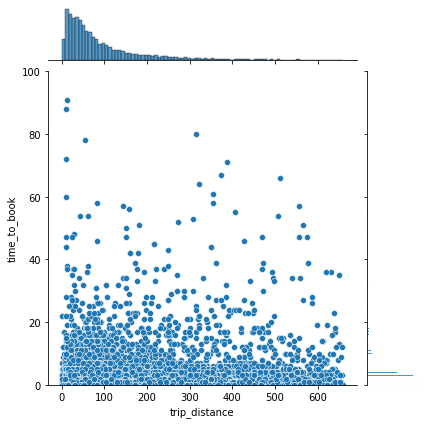

In [66]:
plt.figure(figsize=(15,15))
# sns.scatterplot(data=X, x='trip_distance', y='time_to_book')
sns.jointplot(data=X_3[X_3['trip_distance'] <1000], x='trip_distance', y='time_to_book')
plt.xlim(0,1000)
plt.ylim(0,100)
plt.show()

In [67]:
var1='borrower_distance'
var2='time_to_book'

In [68]:
scaler = StandardScaler()
scaler.fit(X_3)
X_3_scaled = scaler.transform(X_3)
X_3_scaled = pd.DataFrame(data=X_3_scaled, columns=X_3.columns)

In [69]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_3_scaled[[var1, var2]])

In [70]:
cluster_centers = pd.DataFrame(columns=[var1, var2], data = kmeans.cluster_centers_)
cluster_centers

,borrower_distance,time_to_book
0,-0.518580,-0.247413
1,1.889313,-0.109227
2,0.426850,10.560776
3,0.379173,3.962098
4,-0.507123,1.057882


In [71]:
cluster_centers.dtypes

borrower_distance    float64
time_to_book         float64
dtype: object

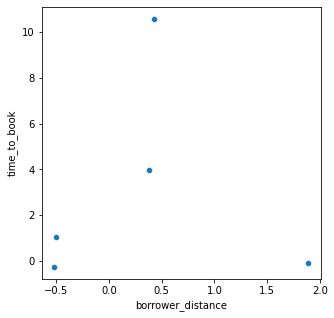

In [72]:
plt.figure(figsize=(5,5))
sns.scatterplot(data=cluster_centers, x=var1, y=var2)
plt.show()

In [73]:
X_3['kmeans'] = kmeans.labels_

In [74]:
X_3.groupby(['kmeans']).agg(['count','mean']).sort_values(by=('trip_distance','mean'))

borrower_distance             trip_duration            trip_distance             time_to_book           
                   count        mean         count       mean         count        mean        count       mean
kmeans                                                                                                         
0                  13468   22.918731         13468  18.965919         13468   96.179388        13468   0.601500
1                   4002  695.334996          4002  25.548226          4002  123.884558         4002   1.200150
4                   1471   26.118198          1471  27.151598          1471  144.367777         1471   6.256288
3                    364  273.620840           364  47.181319           364  210.365385          364  18.837912
2                     73  286.934676            73  62.082192            73  263.630137           73  47.424658

<Figure size 1440x1440 with 0 Axes>

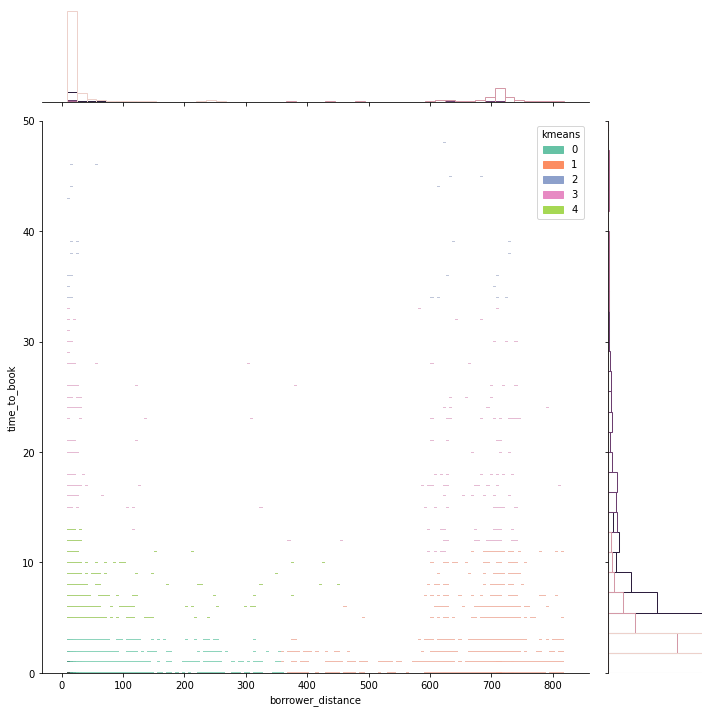

In [75]:
plt.figure(figsize=(20,20))
sns.jointplot(data=X_3, x=var1, y=var2, kind="hist", 
              marginal_kws=dict(bins=50, fill=False),
              hue="kmeans", height=10, palette="Set2")
plt.xlim(0,700)
plt.ylim(0,50)
plt.show()

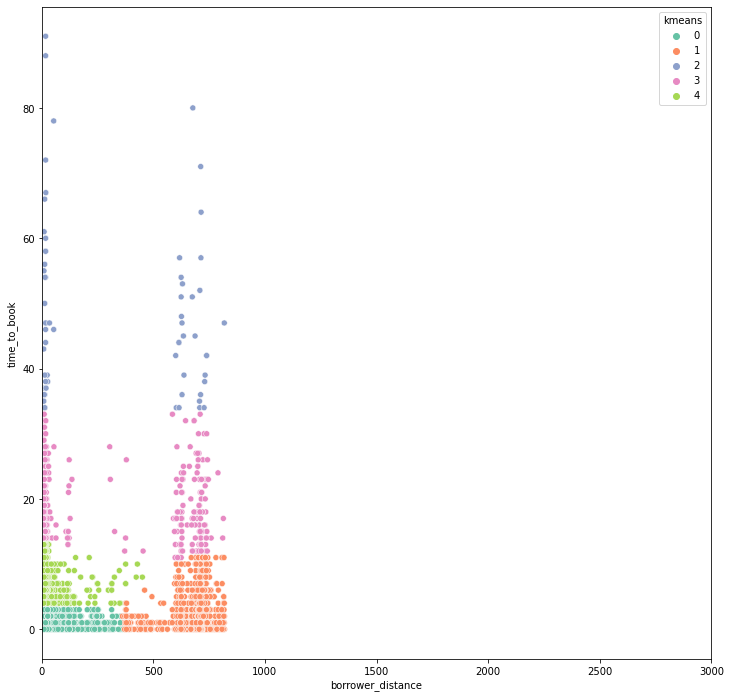

In [76]:
plt.figure(figsize=(12,12))
sns.scatterplot(data=X_3, x=var1, y=var2,
              hue="kmeans", palette="Set2", y_jitter=.3)
plt.xlim(0,3000)
# plt.ylim(0,700)
plt.show()

<Figure size 864x864 with 0 Axes>

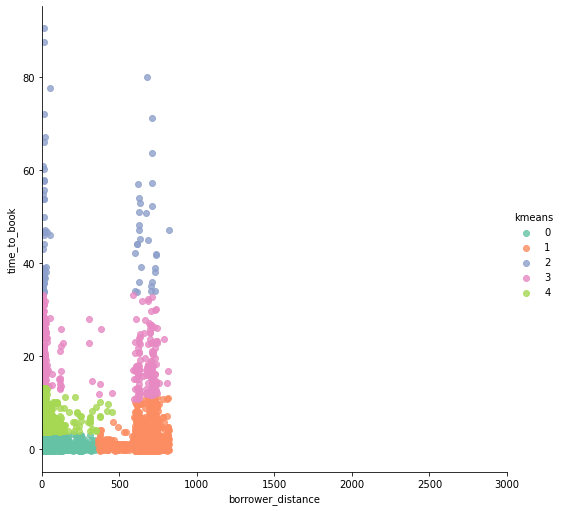

In [77]:
plt.figure(figsize=(12,12))
sns.lmplot(data=X_3, x=var1, y=var2, y_jitter=.3,
            hue="kmeans", palette="Set2",
            fit_reg=False, height=7)
# plt.xlim(0,50)
plt.xlim(0,3000)
plt.show()

In [78]:
X_3.groupby(['kmeans']).count()['trip_duration']

kmeans
0    13468
1     4002
2       73
3      364
4     1471
Name: trip_duration, dtype: int64

In [79]:
X_3.groupby(['kmeans']).describe().sort_values(by=('borrower_distance','max'))

borrower_distance                                                                                     trip_duration                                                     trip_distance                                                           time_to_book                                                    
                   count        mean         std         min         25%         50%         75%         max         count       mean        std  min   25%   50%   75%    max         count        mean         std   min   25%    50%     75%    max        count       mean        std   min   25%   50%   75%   max
kmeans                                                                                                                                                                                                                                                                                                                 
0                13468.0   22.918731   36.960046    8.000120    9.979589   13.052617   19.594014  362.144274       13468.0  18.965919  29.897567  0.0   2.0   7.0  23.0  214.0       13468.0   96.179388  108.453515   1.0  29.0   57.5  116.00  659.0      13468.0   0.601500   0.842997   0.0   0.0   0.0   1.0   3.0
4                 1471.0   26.118198   45.990040    8.011623   10.062505   13.232390   20.298689  450.873861        1471.0  27.151598  33.417654  1.0   7.0  13.0  34.0  200.0        1471.0  144.367777  145.949950   1.0  45.0   88.0  191.50  658.0       1471.0   6.256288   2.399600   4.0   4.0   5.0   7.0  13.0
3                  364.0  273.620840  319.974535    8.041021   11.195406   21.850172  646.281163  813.561066         364.0  47.181319  38.807927  1.0  17.0  36.0  71.0  198.0         364.0  210.365385  168.137426   2.0  68.0  158.0  322.00  651.0        364.0  18.837912   5.311622  11.0  14.0  17.0  22.0  33.0
2                   73.0  286.934676  326.886914    8.592412   13.992872   19.250682  630.547684  817.932983          73.0  62.082192  44.344220  5.0  26.0  52.0  84.0  195.0          73.0  263.630137  199.955516  10.0  63.0  222.0  427.00  650.0         73.0  47.424658  13.290470  34.0  37.0  44.0  54.0  91.0
1                 4002.0  695.334996   58.572574  361.356167  694.386631  710.825896  718.579056  818.790997        4002.0  25.548226  33.162409  1.0   4.0  10.0  33.0  214.0        4002.0  123.884558  128.562337   1.0  31.0   76.0  174.75  652.0       4002.0   1.200150   1.960665   0.0   0.0   1.0   1.0  11.0

In [80]:
X_3.loc[X_3['borrower_distance'] > 600, 'traveller_split'] = 'traveller'
X_3.loc[X_3['borrower_distance'] <= 600, 'traveller_split'] = 'commuter'

<Figure size 864x864 with 0 Axes>

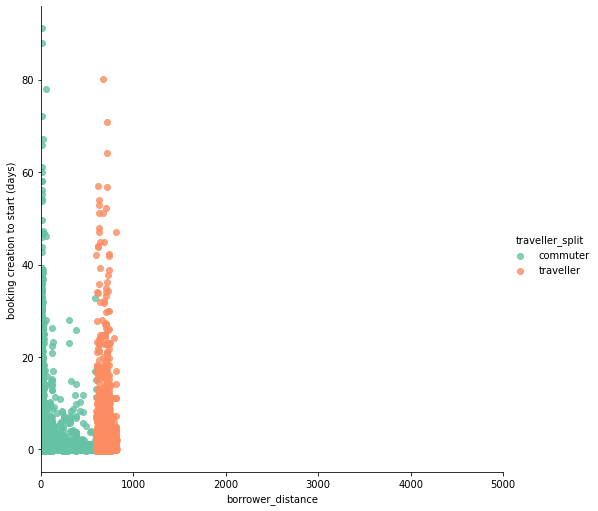

In [81]:
plt.figure(figsize=(12,12))
sns.lmplot(data=X_3, x=var1, y=var2, y_jitter=.3,
            hue="traveller_split", palette="Set2",
            fit_reg=False, height=7)
# plt.xlim(0,50)
plt.xlim(0,5000)
plt.ylabel('booking creation to start (days)')
plt.show()

In [82]:
X_3.groupby(['traveller_split']).count()['trip_duration']

traveller_split
commuter     15355
traveller     4023
Name: trip_duration, dtype: int64

# Standardize definition of segments 

In [83]:
# ute_borrowers = trip_details[trip_details['car_type'].isin(['Van / People Mover','Ute']) & 
#                              (trip_details['trip_completed'] == 'Yes') & 
#                              (trip_details['trip_distance'] > 0)].copy(deep=True)

In [84]:
# car_borrowers = trip_details[(trip_details['car_type'].isin(['Car','SUV / 4WD'])) & 
#                              (trip_details['trip_completed'] == 'Yes') & 
#                              (trip_details['trip_distance'] > 0)].copy(deep=True)

In [156]:
car_sharers = car_borrowers[car_borrowers['borrower_distance'] < 600]

In [157]:
car_tourists = car_borrowers[car_borrowers['borrower_distance'] >= 600]

# Separate data per state / city

In [158]:
car_sharers.groupby(['car_state']).agg({'count':'sum',
                                        'member_id':lambda x: x.nunique()}).reset_index()\
    .sort_values(by=['member_id'],ascending=False)

,car_state,count,member_id
1,NSW,126178,37469
5,VIC,81502,27949
2,QLD,23210,10579
6,WA,2832,1518
0,ACT,1502,932
4,TAS,486,340
7,unknown,72,41
3,SA,30,20


In [159]:
car_sharers.pivot_table(index='car_state', columns='gender',
                        values=['member_id','count', 'age'], aggfunc={'member_id':lambda x: x.nunique()
                                                              , 'count':'sum', 'age':'mean'}
                       ).fillna(0).round(1)

age                count                 member_id               
gender    female  male other   female     male  other    female     male other
car_state                                                                     
ACT         35.9  35.0  40.0    583.0    910.0    1.0     331.0    594.0   1.0
NSW         33.2  34.1  33.0  42265.0  80610.0  126.0   12524.0  24301.0  40.0
QLD         35.2  36.2  31.1   7847.0  15266.0   30.0    3538.0   7004.0  13.0
SA          34.9  36.2   0.0     15.0     14.0    0.0       6.0     13.0   0.0
TAS         38.7  36.0   0.0    234.0    247.0    0.0     137.0    200.0   0.0
VIC         34.0  34.2  36.9  29341.0  49944.0  314.0    9883.0  17603.0  71.0
WA          34.6  36.0  27.0    908.0   1918.0    2.0     537.0    976.0   1.0
unknown     33.4  37.0   0.0     38.0     32.0    0.0      21.0     18.0   0.0

In [160]:
car_tourists.groupby(['car_state']).agg({'count':'sum',
                                        'member_id':lambda x: x.nunique()}).reset_index()\
    .sort_values(by=['member_id'],ascending=False)

,car_state,count,member_id
3,QLD,7670,5482
6,VIC,4750,3058
1,NSW,5467,2967
5,TAS,902,786
7,WA,1175,743
0,ACT,128,104
4,SA,24,19
8,unknown,18,16
2,NT,14,12


In [161]:
car_tourists.pivot_table(index='car_state', columns='gender',
                        values=['member_id','count', 'age'], aggfunc={'member_id':lambda x: x.nunique()
                                                              , 'count':'sum', 'age':'mean'}
                       ).fillna(0).round(1)

age               count               member_id              
gender    female  male other  female    male other    female    male other
car_state                                                                 
ACT         37.3  39.4   0.0    60.0    67.0   0.0      49.0    54.0   0.0
NSW         32.8  33.6  34.3  2157.0  3242.0   3.0    1177.0  1748.0   3.0
NT          40.2  29.2   0.0     6.0     8.0   0.0       6.0     6.0   0.0
QLD         34.5  36.0  40.6  2778.0  4803.0   7.0    2090.0  3343.0   4.0
SA          35.0  31.0   0.0     8.0    16.0   0.0       7.0    12.0   0.0
TAS         33.2  35.1  26.0   355.0   529.0   1.0     313.0   456.0   1.0
VIC         33.1  33.8  33.0  1620.0  2989.0  26.0    1080.0  1913.0  10.0
WA          32.3  35.0   0.0   445.0   715.0   0.0     270.0   462.0   0.0
unknown     32.6  35.7   0.0     8.0    10.0   0.0       7.0     9.0   0.0

In [162]:
ute_borrowers.groupby(['car_state']).agg({'count':'sum',
                                        'member_id':lambda x: x.nunique()}).reset_index()\
    .sort_values(by=['member_id'],ascending=False)

,car_state,count,member_id
1,NSW,980,213
4,VIC,890,165
2,QLD,354,97
5,WA,73,19
3,TAS,33,10
6,unknown,38,10
0,ACT,13,5


In [163]:
ute_borrowers.pivot_table(index='car_state', columns='gender',
                        values=['member_id','count', 'age'], aggfunc={'member_id':lambda x: x.nunique()
                                                              , 'count':'sum', 'age':'mean'}
                       ).fillna(0).round(1)

age        count      member_id     
gender    female  male female male    female male
car_state                                        
ACT         34.7  35.7     10    3         3    2
NSW         37.6  34.8    146  807        36  170
QLD         41.0  36.9     30  323        15   81
TAS         66.0  34.5     17   16         1    9
VIC         35.9  36.9    110  765        23  138
WA          23.0  39.8      1   71         1   17
unknown     46.0  43.3      3   35         2    8

# Get overlap between segments 

In [164]:
car_sharer_merge = car_sharers.groupby(['member_id','car_state']).sum()[['count']].reset_index()
car_tourists_merge = car_tourists.groupby(['member_id','car_state']).sum()[['count']].reset_index()
ute_borrowers_merge = ute_borrowers.groupby(['member_id','car_state']).sum()[['count']].reset_index()

In [165]:
sharer_vs_tourist = car_sharer_merge.merge(car_tourists_merge, on='member_id', how='inner', suffixes=('_sharer','_tourist'))
sharer_vs_tourist.pivot_table(index='car_state_sharer', columns='car_state_tourist',
                              values='member_id', aggfunc='count',
                              margins=True).fillna(0)

car_state_tourist,ACT,NSW,NT,QLD,SA,TAS,VIC,WA,unknown,All
car_state_sharer,,,,,,,,,,
ACT,3.0,6.0,0.0,23.0,0.0,6.0,3.0,2.0,0.0,43
NSW,1.0,333.0,3.0,643.0,1.0,132.0,479.0,90.0,0.0,1682
QLD,13.0,161.0,0.0,550.0,0.0,20.0,128.0,30.0,5.0,907
SA,0.0,2.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,6
TAS,1.0,13.0,0.0,15.0,0.0,31.0,6.0,1.0,0.0,67
VIC,1.0,464.0,0.0,558.0,4.0,51.0,1068.0,64.0,7.0,2217
WA,1.0,28.0,1.0,23.0,0.0,3.0,17.0,140.0,1.0,214
unknown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
All,20.0,1007.0,4.0,1813.0,7.0,243.0,1702.0,328.0,13.0,5137


In [166]:
sharer_vs_ute = car_sharer_merge.merge(ute_borrowers_merge, on='member_id', how='inner', suffixes=('_sharer','_ute'))
sharer_vs_ute.pivot_table(index='car_state_sharer', columns='car_state_ute',
                              values='member_id', aggfunc='count',
                              margins=True).fillna(0)

car_state_ute,ACT,NSW,QLD,TAS,VIC,WA,unknown,All
car_state_sharer,,,,,,,,
ACT,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2
NSW,0.0,54.0,6.0,0.0,2.0,1.0,0.0,63
QLD,0.0,1.0,16.0,0.0,1.0,0.0,0.0,18
TAS,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2
VIC,0.0,3.0,2.0,0.0,59.0,1.0,3.0,68
WA,0.0,0.0,0.0,0.0,0.0,6.0,0.0,6
All,1.0,58.0,25.0,2.0,62.0,8.0,3.0,159


In [167]:
tourist_vs_ute = car_tourists_merge.merge(ute_borrowers_merge, on='member_id', how='inner', suffixes=('_tourist','_ute'))
tourist_vs_ute.pivot_table(index='car_state_tourist', columns='car_state_ute',
                              values='member_id', aggfunc='count',
                              margins=True).fillna(0)

car_state_ute,ACT,NSW,QLD,TAS,VIC,WA,unknown,All
car_state_tourist,,,,,,,,
NSW,0.0,15.0,4.0,0.0,4.0,0.0,1.0,24
QLD,1.0,8.0,22.0,0.0,3.0,1.0,1.0,36
TAS,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2
VIC,0.0,2.0,2.0,0.0,12.0,0.0,1.0,17
WA,0.0,1.0,1.0,0.0,1.0,5.0,0.0,8
All,1.0,26.0,29.0,2.0,20.0,6.0,3.0,87


# Percentage per segment 

In [168]:
total_car_sharers = car_sharers.groupby(['member_id']).count().count()['count']
total_car_tourists = car_tourists.groupby(['member_id']).count().count()['count']
total_car_borrowers = car_borrowers.groupby(['member_id']).count().count()['count']
total_ute_borrowers = ute_borrowers.groupby(['member_id']).count().count()['count']

In [169]:
print("Percentage of car sharer segment :", total_car_sharers / (total_car_borrowers + total_ute_borrowers) * 100)

Percentage of car sharer segment : 89.53757687085697


In [170]:
print("Percentage of car tourist segment :", total_car_tourists / (total_car_borrowers + total_ute_borrowers) * 100)

Percentage of car tourist segment : 14.434036532910424


In [171]:
print("Percentage of ute borrower segment :", total_ute_borrowers / (total_car_borrowers + total_ute_borrowers) * 100)

Percentage of ute borrower segment : 0.5510741953518089


# Car sharer - tourist analysis

In [88]:
car_sharer_merge.groupby(['car_state']).agg({'member_id':'count',
                                             'count':['mean','std']})

member_id     count          
              count      mean       std
car_state                              
ACT             283  1.530035  1.471351
NSW           27620  3.237654  6.509422
QLD            5022  2.180207  3.528187
VIC           22556  3.003901  5.118588
WA              265  1.671698  2.222848
unknown          54  1.222222  0.571878

In [89]:
car_sharer_merge.quantile(.95)

member_id    473479.1
count            10.0
Name: 0.95, dtype: float64

(-1.0, 10.0)

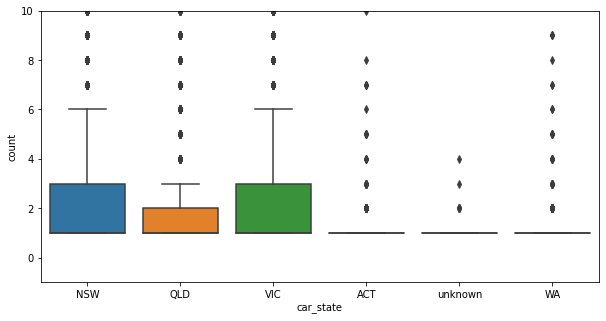

In [90]:
plt.figure(figsize=(10,5))
sns.boxplot(data=car_sharer_merge, x='car_state', y='count')
plt.ylim(-1,10)

In [91]:
sharer_vs_tourist.groupby(['car_state_sharer']).agg({'member_id':'count',
                                             'count_sharer':['mean','std']})

member_id count_sharer           
                     count         mean        std
car_state_sharer                                  
ACT                     18     1.555556   1.688098
NSW                   1024     5.471680  10.698169
QLD                    335     3.432836   7.339549
VIC                   1308     5.866208  10.622463
WA                      41     3.682927   6.373535
unknown                  2     1.000000   0.000000

(-1.0, 10.0)

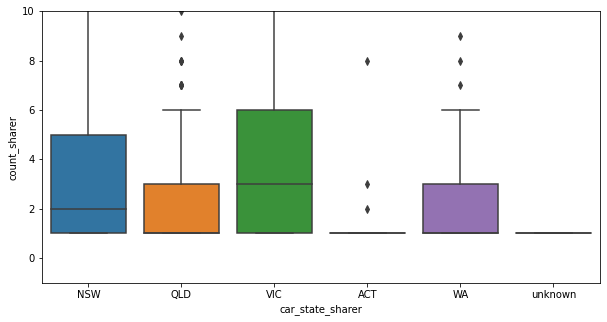

In [92]:
plt.figure(figsize=(10,5))
sns.boxplot(data=sharer_vs_tourist, x='car_state_sharer', y='count_sharer')
plt.ylim(-1,10)

In [93]:
sharer_tourist_rides = car_sharer_merge.groupby(['car_state']).mean()[['count']].reset_index()\
        .merge(sharer_vs_tourist.groupby(['car_state_sharer']).mean()[['count_sharer']].reset_index(),
              left_on='car_state', right_on='car_state_sharer')
sharer_tourist_rides

,car_state,count,car_state_sharer,count_sharer
0,ACT,1.530035,ACT,1.555556
1,NSW,3.237654,NSW,5.471680
2,QLD,2.180207,QLD,3.432836
3,VIC,3.003901,VIC,5.866208
4,WA,1.671698,WA,3.682927
5,unknown,1.222222,unknown,1.000000


In [94]:
sharer_tourist_rides.columns = ['home_state', 'sharer_trips', 'tourist_state', 'sharer_tourist_trips']

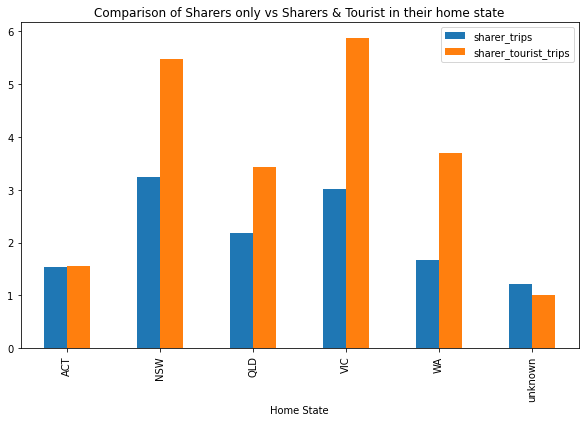

In [95]:
sharer_tourist_rides.plot(x='home_state', kind='bar', figsize=(10,6))
plt.title("Comparison of Sharers only vs Sharers & Tourist in their home state")
plt.xlabel('Home State')
plt.show()


# Interstate analysis

In [105]:
interstate_per_member = interstate_trips.groupby('member_id').count()[['count']].reset_index()
interstate_per_member.groupby(['count']).count().head(10)

NameError: name 'interstate_trips' is not defined

Inter-state trips are clear cut in terms of distances, with its 25th percentile (707km) way above the 90th percentile (33km) of distance over all trips

However, this capturse less than 10% of all trips

In [ ]:
interstate_trips['distance'].describe()

In [ ]:
interstate_trips = trip_details[(trip_details['trip_completed'] == 'Yes') & 
             (trip_details['member_state'] != trip_details['car_state'])]
interstate_trips.groupby(['distance_decile']).count()[['member_id']]

In [ ]:
interstate_trips

In [ ]:
trip_details.loc[trip_details['car_state'] == 'New South Wales', 'car_state'] = 'NSW'
trip_details.loc[trip_details['car_state'] == 'Queensland', 'car_state'] = 'QLD'
trip_details.loc[trip_details['car_state'] == 'Victoria', 'car_state'] = 'VIC'
trip_details.loc[trip_details['car_state'] == 'Australian Capital Territory', 'car_state'] = 'ACT'
trip_details.loc[trip_details['car_state'] == 'Tasmania', 'car_state'] = 'TAS'
trip_details.loc[trip_details['car_state'] == 'Western Australia', 'car_state'] = 'WA'
trip_details.loc[trip_details['car_state'] == 'South Australia', 'car_state'] = 'SA'
trip_details.loc[trip_details['car_state'] == 'Northern Territory', 'car_state'] = 'NT'

In [ ]:
trip_details['member_state'].unique()

In [ ]:
trip_details['car_state'].unique()

## Look at inter-state distances 

In [ ]:
plt.figure(figsize=(12,7))
sns.histplot(trip_details[(trip_details['trip_completed'] == 'Yes') & 
             (trip_details['end_month'] == '2021-07') & 
             (trip_details['distance'] < 50) & 
             (trip_details['distance'] > 5)]['distance'], binwidth=1)

In [ ]:
trip_details[trip_details['trip_completed'] == 'Yes'].groupby('end_month').agg(mean = ('distance',lambda x: x.mean()),
                                                                               percentile_50 = ('distance',lambda x: x.quantile(0.5)),
                                                                               percentile_80 = ('distance',lambda x: x.quantile(0.8)),
                                                                               percentile_95 = ('distance',lambda x: x.quantile(0.95))
                                                                               )

In [ ]:
trip_details[trip_details['trip_completed'] == 'Yes'].agg(percentile_50 = ('distance',lambda x: x.quantile(0.5)),
                                                                               percentile_80 = ('distance',lambda x: x.quantile(0.8)),
                                                                               percentile_95 = ('distance',lambda x: x.quantile(0.95))
                                                                               )

In [ ]:
distance_deciles =  pd.qcut(trip_details[trip_details['trip_completed'] == 'Yes']['borrower_distance'], 
                             q = 10).value_counts().to_frame()
distance_deciles.reset_index().sort_values(by='index')                             

Cumulative percentage of borrowers based on number of completed trips. From this, if we specify at least 3 trips to segment a user,  we will only capture less than 20%

# Totals 

- 87480 total borrowers
- 78477 total car sharers
- 12651 total car tourists
- 483 total van borrowers

In [133]:
78477/87480 * 100

89.70850480109739

In [134]:
12651/87480 * 100

14.461591220850481

In [135]:
483/87480 * 100

0.5521262002743484

In [136]:
89.70850480109739 + 14.461591220850481 + 0.5521262002743484

104.72222222222221